In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf as erf
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

0.2875


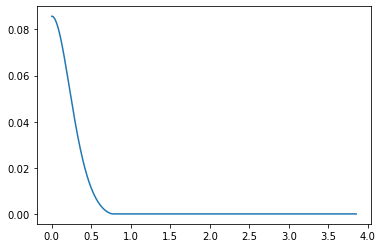

In [2]:
# set some parameters

Mscale = 2.325e9
Vscale = 100
RSun = 8.
Vcirc = 230
Omega = Vcirc/Vscale/RSun
# Mestel disk has A = Omega/2 = -B
A = 0.5*Omega
B = A - Omega
kappa = np.sqrt(-4.*B*Omega)

sigz = 0.025
Q = 1.
SurfaceDensity = 12e7/Mscale
E0s2 = 3.


def dydx(sigz,E0,y):
    dy = np.zeros(2)
    dy[0] = y[1]
    rho = rho_of_psi(sigz,E0,y[0])
    dy[1] = 4.*np.pi*rho 
    return dy

def rk4(sigz,E0,y,h):
    k1 = dydx(sigz,E0,y)
    k2 = dydx(sigz,E0,y+h*k1/2)
    k3 = dydx(sigz,E0,y+h*k2/2)
    k4 = dydx(sigz,E0,y+h*k3)
    return y + h*(k1+2*k2+2*k3+k4)/6.

def rho_of_psi(sigz,E0,psi):
    if psi > E0:
        return 0.
    u = np.sqrt(E0-psi)/sigz
    return rho0*(np.exp(-psi/sigz**2)*erf(u)-2./np.sqrt(np.pi)*u*np.exp(-E0/sigz**2))

def VerticalStructure(Q,SurfDens,E0s2,sigz):
    global psifromz, zfrompsi, forcefromz
    global rho0,kcrit,lcrit,sigx,hz,nuz,nz,zgrid
    global ICDensity,ICForce,ICPotential
    global E0
    E0 = E0s2*sigz**2
    nz = 1000
    hz = sigz**2/(2*np.pi*SurfDens)
    zmx = 20.*hz
    zgrid = np.linspace(0.,zmx,nz,endpoint=False)
    dz = zgrid[1]-zgrid[0]
    ICForce = np.zeros(nz)
    ICPotential = np.zeros(nz)
    ICDensity = np.zeros(nz)
    rho0 = 10.*SurfDens/hz
    for j in range(20):
        y = (ICPotential[0],ICForce[0])
        ICDensity[0] = rho_of_psi(sigz,E0,0.0)
        SD = 0.
        for i in range(1,nz):
            y = rk4(sigz,E0,y,dz)
            ICPotential[i], ICForce[i] = y
            ICDensity[i] = rho_of_psi(sigz,E0,ICPotential[i])
            if ICDensity[i]>0:
                SD += 0.5*(ICDensity[i]+ICDensity[i-1])*dz
        SD = 2.*SD
        MassScaleFactor = SurfDens/SD
        rho0 = rho0*MassScaleFactor
    kcrit = kappa**2/2./np.pi/SurfDens
    lcrit = 2.*np.pi/kcrit
    sigx = 3.36*Q*SurfDens/kappa
    Jeans = sigx**2/SurfDens
    Repicycle = sigx/kappa
    Lindblad_kcrit = kappa/2/A/kcrit
    iz0 = int(nz/50)
    nuz = np.sqrt(np.sum(2*ICPotential[:iz0])/np.sum(zgrid[:iz0]**2))
    psifromz = interpolate.interp1d(zgrid,ICPotential,fill_value='extrapolate')
    zfrompsi = interpolate.interp1d(ICPotential,zgrid,fill_value='extrapolate')
    forcefromz = interpolate.interp1d(zgrid,ICForce,fill_value='extrapolate')
    """
    print ('check convergence of SurfaceDensity',MassScaleFactor)
    print ('central density',ICDensity[0])
    print ('Omega, Oort A and B',Omega,A,B)
    print ('epicycle kappa',kappa)
    print ('surface density',SurfDens,SurfDens*Mscale/1e6)
    print ('vertical scale height parameter',hz)
    print ('critical wavelength',lcrit)
    print ('sigma x',sigx)
    print ('Jeans length',Jeans)
    print ('Epicycle radius',Repicycle)
    print ('Lindblad resonances for critial k',Lindblad_kcrit)
    print ('midplane vertical frequency',nuz)
    """
    return 

Q = 1.4
sigz = 0.25
E0s2 = 3.

VerticalStructure(Q,SurfaceDensity,E0s2,sigz)
print (2*A)

plt.plot(zgrid,ICDensity)

In [3]:
def get_bc_vectors(t,s,ky):
    Ct = np.cos(kappa*t)
    Cs = np.cos(kappa*s)
    St = np.sin(kappa*t)
    Ss = np.sin(kappa*s)
    bx = ky/kcrit*(A*(s*Ss-t*St)+Omega/kappa*(Cs-Ct))
    by = ky/kcrit*(A*(s*Cs-t*Ct)-Omega/kappa*(Ss-St))
    cx = -A*s*Cs + Omega/kappa*Ss
    cy =  A*s*Ss + Omega/kappa*Cs
    return bx,by,cx,cy

def get_ampfac(s):
    return (1. + (2*A*s)**2)**(-.5)

def argexp(b2):
    return -0.572*Q**2*b2

def get_Kpts(t,s,ky):
    bx,by,cx,cy = get_bc_vectors(t,s,ky)
    cdotb = bx*cx + by*cy
    b2 = bx*bx + by*by
    ampfac = get_ampfac(s)
    return 4*cdotb*np.exp(argexp(b2))*ampfac

def get_Kzts(t,s,ky):
    bx,by,cx,cy = get_bc_vectors(t,s,ky)
    b2 = bx*bx + by*by
    ampfac = get_ampfac(s)
    return np.exp(argexp(b2))

In [4]:
# get vertical structure
# need rho0 (midplane density), E0 (energy cut-off)
# and sigz (vertical velocity dispersion)

def loweredisothermal(sigz,E0,E):
    if E > E0:
        return 0.
    f0 = rho0/np.sqrt(2.*np.pi)/sigz
    return f0*(np.exp(-E/sigz**2) - np.exp(-E0/sigz**2))

def dloweredisothermal(sigz,E0,E):
    if E >= E0:
        return 0.
    f0 = rho0/np.sqrt(2.*np.pi)/sigz
    return f0*np.exp(-E/sigz**2)

def loweredisothermalA(sigz,E0,E):
    f0 = np.zeros_like(E)
    cnd = E<E0
    f0[cnd] = rho0/np.sqrt(2.*np.pi)/sigz*(np.exp(-E[cnd]/sigz**2)-np.exp(-E0/sigz**2))
    return f0

def dloweredisothermalA(sigz,E0,E):
    f0 = np.zeros_like(E)
    cnd = E<E0
    f0[cnd] = rho0/np.sqrt(2.*np.pi)/sigz*np.exp(-E[cnd]/sigz**2)
    return f0

In [5]:
def set_xygrid(nx,ny,xmax,ymax):
    global dx,dy,xgrid,ygrid,xmesh,ymesh
    xgrid = np.linspace(-xmax,xmax,nx)
    dx = xgrid[1]-xgrid[0]
    ygrid = np.linspace(-ymax,ymax,ny)
    dy = ygrid[1]-ygrid[0]
    xmesh,ymesh = np.meshgrid(xgrid,ygrid,indexing='ij')

nx = 33
ny = 65

set_xygrid(nx,ny,lcrit/2.,lcrit)

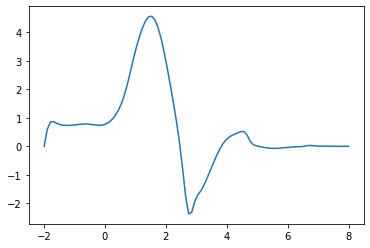

In [6]:
tscale = np.pi/kappa
kytest = kcrit/2.

def get_tgrid(ti,tf,nt):
    global dt,t
    t = np.linspace(ti,tf,nt)
    dt = t[1]-t[0]
    return 

tstart = -2.*tscale
tend = 8*tscale
ntime = 100
get_tgrid(tstart,tend,ntime)

Sigma = np.zeros(ntime)
for j in range(ntime):
    Sigma[j] = get_Kpts(t[j],tstart,kytest)
    for k in range(1,j):
        Sigma[j] += dt*kappa*get_Kpts(t[j],t[k],kytest)*(Sigma[k])
        
plt.plot(t/tscale,Sigma)

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  

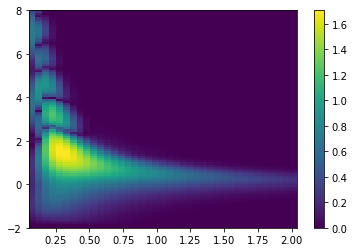

In [7]:
#make Binney Figure 9

def set_kgrid(ikmax,nky,dt,t):
    global dky,ky,tmesh,kxmesh,kymesh
    kymax = ikmax*kcrit
    dky = kymax/np.float(nky)
    ky = np.linspace(dky,kymax,nky)
    dkx = dt*2*A*ky
    kymesh,tmesh = np.meshgrid(ky,t,indexing='ij')
    kxmesh = -2*A*kymesh*tmesh
    return 

iky = 4.
nky = 40

set_kgrid(iky,nky,dt,t)

Delta = 0.05*lcrit

CloudFT = np.exp(-(kxmesh**2 + kymesh**2)*Delta**2/2.)

Sigma_k = np.zeros((nky,ntime))

for i in range(nky):
    print (i,end='  ')
    for j in range(ntime):
        for k in range(1,j):
            Sigma_k[i,j] += dt*kappa*get_Kpts(t[j],t[k],ky[i])*(1 + Sigma_k[i,k])
Sigma_k *= CloudFT
vmx = np.log10(Sigma_k.max())
c = plt.pcolormesh(kymesh,tmesh/tscale,np.log10(np.abs(Sigma_k)+1),vmax=vmx,vmin=0)
plt.colorbar(c)
plt.show()

In [8]:
def IFT_Sigma(Sigma):
    print (kxmesh.shape,xmesh.shape,nky,ntime,nx,ny)
    arg = 1j*(np.outer(kxmesh,xmesh)+np.outer(kymesh,ymesh)).reshape(nky,ntime,nx,ny)
    FT = np.exp(arg)*Sigma[:,:,None,None]*ky[:,None,None,None]
    Sigma_x = np.sum(FT+np.conj(FT),axis=(0,1))*dky*2*A*dt/(2.*np.pi)**2/(0.1*lcrit)**2
    Sigma_x = np.real(Sigma_x)
    return Sigma_x

def Plot_Sigma(Sigma,nlev,plev):
    fig,ax = plt.subplots(1,1,figsize=(8,4))
    c = plt.contour(ymesh/lcrit,xmesh/lcrit,np.real(Sigma_x),levels=nlev,colors='red',linestyles=("-"))
    c = plt.contour(ymesh/lcrit,xmesh/lcrit,np.real(Sigma_x),levels=(0.,0.001),colors='black',linestyles="--")
    c = plt.contour(ymesh/lcrit,xmesh/lcrit,np.real(Sigma_x),levels=plev,colors='black',linestyles="-")
    plt.colorbar(c)

#nlev = (-1,-0.5)
#plev = (.5,1,1.5,2)
    
Sigma_x = IFT_Sigma(Sigma_k)
#Plot_Sigma(Sigma_x)


(40, 100) (33, 65) 40 100 33 65


In [9]:
def dydxa(Em,t,z):
    psi = psifromz(z)
    if Em < psi:
        return 0.
    return (1./np.sqrt(2.*(Em-psi)))

def rk4a(Em,t,z,h):
    k1 = dydxa(Em,t,z)
    k2 = dydxa(Em,t+h*k1/2,z+h/2)
    k3 = dydxa(Em,t+h*k2/2,z+h/2)
    k4 = dydxa(Em,t+h*k3,z+h)
    return t + h*(k1+2*k2+2*k3+k4)/6.

def dydxb(Em,z,t):
    psi = psifromz(z)
    if Em < psi:
        return 0.
    return (np.sqrt(2.*(Em-psi)))

def rk4b(Em,z,t,h):
    k1 = dydxb(Em,z,t)
    k2 = dydxb(Em,z+h*k1/2,t+h/2)
    k3 = dydxb(Em,z+h*k2/2,t+h/2)
    k4 = dydxb(Em,z+h*k3,t+h)
    return z + h*(k1+2*k2+2*k3+k4)/6.

nE = 100
nz = 100
nt = 100

def InterpolatingFunctions(nE,nz,nt):
    global PeriodfromE, thetainterp, zoftinterp
    Eg = np.linspace(0,E0,nE)
    zmax = zfrompsi(Eg)
    zmax[0] = zfrompsi(Eg[1]/100)
    tofEz = np.zeros((nE,nz))
    zg = np.linspace(0,zmax[0],nz)
    zgs = np.linspace(0,1,nz)
    tofEz[0,:] = 1/nuz*np.arcsin(zg/zmax[0])
    for i in range(1,nE):
        zg = np.linspace(0,zmax[i],nz)
        h = zg[1]-zg[0]
        for j in range(1,nz-1):
            tofEz[i,j] = rk4a(Eg[i],tofEz[i,j-1],zg[j-1],h)
        lastz = np.sqrt(2.*h/forcefromz(zg[nz-1]))
        tofEz[i,nz-1] = tofEz[i,nz-2] + lastz
    
    Period = 4.*tofEz[:,nz-1]
    PeriodfromE = interpolate.interp1d(Eg,Period,fill_value='extrapolate')
    theta = np.zeros_like(tofEz)
    
    for i in range(0,nE):
        theta[i,:] = 2.*np.pi*tofEz[i,:]/Period[i]
    
    zofEt = np.zeros((nE,nt))
    thetag = np.linspace(0,np.pi/2,nt)
    for i in range(1,nE):
        tg = np.linspace(0,Period[i]/4.,nt)
        h = tg[1]-tg[0]
        for j in range(1,nt):
            zofEt[i,j] = rk4b(Eg[i],zofEt[i,j-1],tg[j-1],h)
    thetainterp = RegularGridInterpolator((Eg,zgs),theta,bounds_error=False)
    zoftinterp = RegularGridInterpolator((Eg,thetag),zofEt,bounds_error=False)
    return 
InterpolatingFunctions(nE,nz,nt)

In [10]:
def thetafromzw(z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    if E >= E0:
        return 0.
    zmx = zfrompsi(E)
    theta = thetainterp((E,np.abs(z)/zmx))
    if z > 0 and w < 0:
        return np.pi - theta
    if z < 0 and w > 0:
        return 2.*np.pi - theta
    if z < 0 and w < 0:
        return np.pi + theta
    return theta

def thetafromzw_fast(z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    zmx = zfrompsi(E)
    theta = np.pi/2.*np.ones_like(E)
    c0b = w!=0
    theta[c0b] = thetainterp((E[c0b],np.abs(z[c0b])/zmx[c0b]))
    c1 = (z>0) & (w<0)
    theta[c1] = np.pi - theta[c1]
    c2 = (z<0) & (w>0)
    theta[c2] = 2.*np.pi - theta[c2]
    c3 = (z<0) & (w<0)
    theta[c3] = np.pi + theta[c3]
    return theta

def wzoftfromEtheta(E,theta):
    zsign = 1
    wsign = 1
    theta = np.mod(theta,2*np.pi)
    if theta > np.pi/2. and theta < np.pi:
        theta = np.pi - theta
        wsign = -1
    if theta > np.pi and theta < 3*np.pi/2.:
        zsign = -1
        wsign = -1
        theta = theta - np.pi
    if theta > 3.*np.pi/2.:
        zsign = -1
        theta = 2*np.pi - theta
    zoft = zoftinterp((E,theta))*zsign
    psi = psifromz(np.abs(zoft))
    if (E < psi):
        woft = 0.
    else:
        woft = np.sqrt(2.*(E - psifromz(np.abs(zoft))))*wsign
    return zoft,woft

def wzoftfromEtheta_fast(E,theta):
    zsign = np.ones_like(E)
    wsign = np.ones_like(E)
    theta = np.mod(theta,2*np.pi)

    cnd = (theta>np.pi/2.) & (theta < np.pi)
    theta[cnd] = np.pi - theta[cnd]
    wsign[cnd] = -1
    
    cnd = (theta > np.pi) & (theta < 3.*np.pi/2.)
    theta[cnd] -= np.pi
    zsign[cnd] = -1
    wsign[cnd] = -1
    
    cnd = theta > 3.*np.pi/2.
    theta[cnd] = 2.*np.pi - theta[cnd]
    zsign[cnd] = -1

    zoft = zoftinterp((E,theta))*zsign
    psi = psifromz(np.abs(zoft))
    cdn = E < psi
    woft = np.zeros_like(E)
    cnd = E > psi
    woft[cnd] = np.sqrt(2.*(E[cnd] - psi[cnd]))*wsign[cnd]
    return zoft,woft

def wzoftfromEtheta_fastest(E,theta):
    zsign = np.ones_like(theta)
    wsign = np.ones_like(theta)
    theta = np.mod(theta,2*np.pi)

    cnd = (theta>np.pi/2.) & (theta < np.pi)
    theta[cnd] = np.pi - theta[cnd]
    wsign[cnd] = -1
    
    cnd = (theta > np.pi) & (theta < 3.*np.pi/2.)
    theta[cnd] -= np.pi
    zsign[cnd] = -1
    wsign[cnd] = -1
    
    cnd = theta > 3.*np.pi/2.
    theta[cnd] = 2.*np.pi - theta[cnd]
    zsign[cnd] = -1

    zoft = zoftinterp((E,theta))*zsign
    psi = psifromz(np.abs(zoft))
    woft = np.zeros_like(theta)
    cnd = E > psi
    woft[cnd] = np.sqrt(2.*(E[cnd] - psi[cnd]))*wsign[cnd]
    return zoft,woft

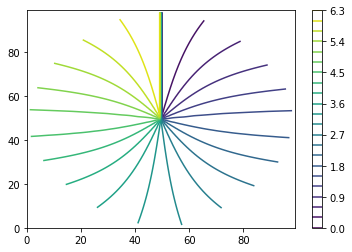

In [11]:
vmax = np.sqrt(2.*E0)
ztrunc = zfrompsi(E0)
vg = np.linspace(-vmax,vmax,nz)
zg = np.linspace(-ztrunc,ztrunc,nz)
zm,vm = np.meshgrid(zg,vg)
tm = thetafromzw_fast(zm,vm)
        
plt.contour(tm,levels=20)
plt.colorbar()

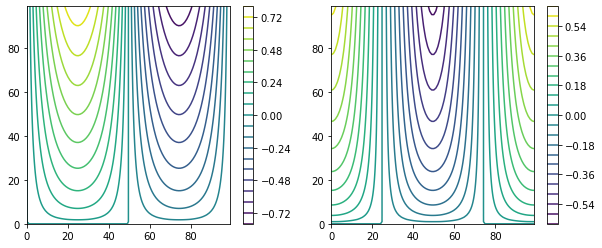

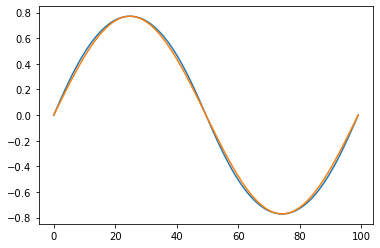

In [12]:
thetagrid = np.linspace(0,2*np.pi,nz)
Egrid = np.linspace(0,E0,nE)
tm,Em = np.meshgrid(thetagrid,Egrid)

zm,wm = wzoftfromEtheta_fast(Em,tm)

f,ax = plt.subplots(1,2,figsize=(10,4))
c0 = ax[0].contour(zm,levels=20)
plt.colorbar(c0,ax=ax[0])
c1 = ax[1].contour(wm,levels=20)
plt.colorbar(c1,ax=ax[1])
plt.show()

plt.plot(zm[nz-1,])
plt.plot(np.sin(thetagrid)*zfrompsi(Egrid[nz-1]))

In [13]:
def ztprime(t,s,z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    if E == 0:
        return 0.0,0.0
    if E > E0:
        print ('here',z,w,E,E0)
        return np.inf,np.inf
    nu = 2.*np.pi/PeriodfromE(E)
    theta = thetafromzw(z,w)
    thetap = theta - nu*(t-s)
    ztp, wtp = wzoftfromEtheta(E,thetap)
    if np.isnan(ztp):
        print (z,w,E,nu,theta,thetap,ztp)
        ;lskdjf
    return ztp, wtp

def ztprime_fast(t,s,z,w):
    E = 0.5*w**2 + psifromz(np.abs(z))
    cnd = E != 0.
    nu = np.zeros_like(z)
    theta = np.zeros_like(z)
    ztp = np.zeros_like(z)
    wtp = np.zeros_like(z)
    nu[cnd] = 2.*np.pi/PeriodfromE(E[cnd])
    theta[cnd] = thetafromzw_fast(z[cnd],w[cnd])-nu[cnd]*(t-s)
    ztp[cnd], wtp[cnd] = wzoftfromEtheta_fast(E[cnd],theta[cnd])
    return ztp, wtp

def ztprime_fastest(t,s,z,w):
    E = (0.5*w**2 + psifromz(np.abs(z)))
    nu = 2.*np.pi/PeriodfromE(E)    
    t1 = thetafromzw_fast(z,w)
    t2 = nu*(t-s)
    theta = t1 - t2
    ztp, wtp = wzoftfromEtheta_fastest(E,theta)
    return ztp, wtp

In [14]:
# in this module, we calculate the normalization factor by 
# integrating the density via loweredisothermal(Ez) over z and w

def get_greensfac(zs,zeta,s,ky):
    kp = ky/get_ampfac(s)
    gf = np.exp(-kp*np.abs(zs-zeta))
    return gf

def set_zwgrid(nPS):
    global dzPS,dwPS,zPS,wPS,zPSM,wPSM,EPSM
    zmaxPS = zfrompsi(E0)
    zPS = np.linspace(-zmaxPS,zmaxPS,nPS)
    dzPS = zPS[1]-zPS[0]
    wmx = np.sqrt(2.*E0)
    dwPS = 2*wmx/np.float(nPS-1)
    wPS = np.linspace(-wmx,wmx,nPS)
    zPSM, wPSM = np.meshgrid(zPS,wPS)
    EPSM = 0.5*wPSM**2 + psifromz(np.abs(zPSM))
    return

nPS = 32

set_zwgrid(nPS)

def get_norm(sigz,E0):
    global normalization
    SDPS = 0.
    for i in range(1,nPS-1):
        psi = psifromz(np.abs(zPS[i]))
        if psi < E0:
            wmx = np.sqrt(2.*(E0-psi))
            wPSN = np.linspace(-wmx,wmx,nPS)
            dwPSN = wPSN[1]-wPSN[0]
            for j in range(1,nPS-1):
                Ez = 0.5*wPSN[j]**2 + psi
                SDPS += dwPSN*dzPS*loweredisothermal(sigz,E0,Ez)
                if np.isnan(SDPS):
                    print (Ez,loweredisothermal(sigz,E0,Ez))
    normalization = 1./SDPS
    return

get_norm(sigz,E0)
print ('normalization',normalization)

def get_df(sigz,E0,Ez):
    return normalization*loweredisothermal(sigz,E0,Ez)

def get_ddf(sigz,E0,Ez):
    ddf = np.zeros_like(Ez)
    ddf[Ez<=E0] = normalization*dloweredisothermal(sigz,E0,Ez)
    return ddf

def get_dfA(sigz,E0,Ez):
    return normalization*loweredisothermalA(sigz,E0,Ez)

def get_ddfA(sigz,E0,Ez):
    return normalization*dloweredisothermalA(sigz,E0,Ez)

def get_fe_zwt(sigz,E0,t,s,z,zeta,w):
    Ez = 0.5*w**2 + psifromz(np.abs(z))
    if Ez >= E0:
        return 0.0,0.0
    zs, ws = ztprime(t,s,z,w)
    greensfac = get_greensfac(zs,zeta,s)
    fpe = greensfac*get_Kpts(t,s)*get_df(sigz,E0,Ez)
    fze = -ws/kappa/hz*greensfac*get_Kzts(t,s)*get_ddf(sigz,E0,Ez)*np.sign(zs-zeta)
    return fpe,fze

def get_fe_zwt_fast(sigz,E0,t,s,z,zeta,w,ky):
    zs = np.zeros_like(z)
    ws = np.zeros_like(z)
    Ez = 0.5*w**2 + psifromz(np.abs(z))
    fpe = np.zeros_like(z)
    fze = np.zeros_like(z)
    cnd = Ez<E0
    zs[cnd], ws[cnd] = ztprime_fast(t,s,z[cnd],w[cnd])
    greensfac = get_greensfac(zs,zeta,s,ky)
    fpe[cnd] = greensfac[cnd]*get_Kpts(t,s,ky)*get_dfA(sigz,E0,Ez[cnd])
    fze[cnd] = -ws[cnd]/kappa/hz*greensfac[cnd]*get_Kzts(t,s,ky)* \
        get_ddfA(sigz,E0,Ez[cnd])*np.sign(zs[cnd]-zeta)
    return fpe,fze

normalization 19.381655191278075


In [15]:
def get_fs_zwt_fast(sigz,E0,t,s,z,w,rho1,ky):
    zs = np.zeros_like(z)
    ws = np.zeros_like(w)
    Ez = 0.5*w**2 + psifromz(np.abs(z))
    cnd = Ez < E0
    zs[cnd], ws[cnd] = ztprime_fast(t,s,z[cnd],w[cnd])
    fps = np.zeros_like(Ez)
    fzs = np.zeros_like(Ez)
    for i in range(1,nPS-1):
        greensfac = np.zeros_like(EPSM)
        greensfac[cnd] = get_greensfac(zs[cnd],zPS[i],s,ky)
        fps[cnd] += greensfac[cnd]*rho1[i]*dzPS
        fzs[cnd] += greensfac[cnd]*rho1[i]*dzPS*ws[cnd]*np.sign(zs[cnd]-zPS[i])
    return fps,fzs

def get_fs_zwt_faster(t,s,z,w,rho1,ky):
    zs = np.zeros_like(z)
    ws = np.zeros_like(w)
    Ez = 0.5*w**2 + psifromz(np.abs(z))
    cnd = Ez < E0
    zs[cnd], ws[cnd] = ztprime_fast(t,s,z[cnd],w[cnd])
    greensfac = get_greensfac(zs[:,:,None],zPS[None,None,:],s,ky)
    ncnd = Ez >= E0
    greensfac[ncnd] = 0.
    argfps = greensfac*rho1[None,None,:]
    argfzs = argfps*ws[:,:,None]*np.sign(zs[:,:,None]-zPS[None,None,:])
    fps = np.trapz(argfps,zPS,axis=2)
    fzs = np.trapz(argfzs,zPS,axis=2)
    return fps,fzs

In [16]:
def InitializeCalculation(Q,sigz,E0s2,nx,ny,nPS,ntime,tstart,tend,nE,nz,nt,mky,nky,Delta):
    global CloudFT
    VerticalStructure(Q,SurfaceDensity,E0s2,sigz)
    set_xygrid(nx,ny,lcrit,2*lcrit)
    set_zwgrid(nPS)
    get_norm(sigz,E0)
    get_tgrid(tstart,tend,ntime)
    InterpolatingFunctions(nE,nz,nt)
    set_kgrid(mky,nky,ntime,t)
    CloudFT = np.exp(-(kxmesh**2 + kymesh**2)*Delta**2/2.)
    return

In [17]:
def RazorThinSigma(kytest,M,Impulse,Q,ntime,tstart,tend):
    get_tgrid(tstart,tend,ntime)
    Sigma_s = np.zeros(ntime)
    Sigma_e = np.zeros(ntime)
    for j in range(ntime):
        Sigma_e[j] = get_Kpts(t[j],tstart,kytest)
        Sigma_s[j] = Impulse*Sigma_e[j]
        for m in range(1,j):
            Sigma_s[j] += dt*kappa*get_Kpts(t[j],t[m],kytest)*(M + Sigma_s[m])
    return Sigma_s,Sigma_e

def CalculateDF(kylim,kytest,M,Impulse,Q,sigz,E0s2,nx,ny,nPS,ntime,tstart,tend,nE,nz,nt,mky,nky,Delta):
    InitializeCalculation(Q,sigz,E0s2,nx,ny,nPS,ntime,tstart,tend,nE,nz,nt,mky,nky,Delta)
    E0 = E0s2*sigz**2
    f_kpe = np.zeros((nky,ntime,nPS,nPS))
    f_kze = np.zeros_like(f_kpe)
    f_kps = np.zeros_like(f_kpe)
    f_kzs = np.zeros_like(f_kpe)
    rho_kps = np.zeros((nky,ntime,nPS))
    rho_kzs = np.zeros_like(rho_kps)
    rho_kts = np.zeros_like(rho_kps)
    rho_kpe = np.zeros_like(rho_kps)
    rho_kze = np.zeros_like(rho_kps)
    Sigma_kps = np.zeros((nky,ntime))
    for k in range(kylim):
        print (k,end=' ')
        if kylim == 1:
            ky[k] = kytest
        for j in range(1,ntime):
            f_kpe[k,j,],f_kze[k,j,] = get_fe_zwt_fast(sigz,E0,t[j],tstart,zPSM,0.0,wPSM,ky[k])
            f_kps[k,j,] = Impulse*f_kpe[k,j,]
            f_kzs[k,j,] = Impulse*f_kze[k,j,]
            for m in range(1,j):
                kpts = kappa*get_Kpts(t[j],t[m],ky[k])
                kzts = -1./hz*get_Kzts(t[j],t[m],ky[k])
                fps,fzs = get_fs_zwt_faster(t[j],t[m],zPSM,wPSM,rho_kts[k,m,],ky[k])
                f_kpex,f_kzex = get_fe_zwt_fast(sigz,E0,t[j],t[m],zPSM,0.0,wPSM,ky[k])
                f_kps[k,j] = M*CloudFT[k,j]*f_kpex + f_kps[k,j] + fps*kpts*get_dfA(sigz,E0,EPSM)*dt
                f_kzs[k,j] = M*CloudFT[k,j]*f_kzex + f_kzs[k,j] + fzs*kzts*get_ddfA(sigz,E0,EPSM)*dt
            rho_kps[k,j,] = np.trapz(f_kps[k,j,],wPS,axis=1)
            rho_kzs[k,j,] = np.trapz(f_kzs[k,j,],wPS,axis=1)
            rho_kpe[k,j,] = np.trapz(f_kpe[k,j],wPS,axis=1)
            rho_kze[k,j,] = np.trapz(f_kze[k,j],wPS,axis=1)  
            rho_kts[k,j,] = rho_kps[k,j,] + rho_kzs[k,j,]   
            Sigma_kps[k,j] = np.trapz(rho_kps[k,j],zPS)
    return f_kps,f_kzs,f_kpe,f_kze

In [18]:
def trap2d(zz,ww,ff):
    rho = np.trapz(np.real(ff),ww,axis=2)
    sig = np.trapz(rho,zz,axis=1)
    return sig

In [19]:
# set up

Q = 1.2
E0s2 = 3.
nx = 30
ny = 60
nPS = 64
ntime = 200
tstart = -2*tscale
tend = 8*tscale
nE = nz = nt = 200
mky = 3
nky = 60

Delta = 0.05*lcrit
M = 1
Impulse = 0
sigz = 0.25

Sigma_s, Sigma_e = RazorThinSigma(kytest,M,Impulse,Q,ntime,tstart,tend)

In [20]:
%%time

f_kps_cloud = np.zeros((nky,ntime,nPS,nPS))
f_kzs_cloud = np.zeros_like(f_kps_cloud)
f_kpe_cloud = np.zeros_like(f_kps_cloud)
f_kze_cloud = np.zeros_like(f_kps_cloud)
f_kpphi = np.zeros_like(f_kps_cloud)
f_kps_cloud,f_kzs_cloud,f_kpe_cloud,f_kze_cloud\
    = CalculateDF(nky,kytest,M,Impulse,Q,sigz,\
    E0s2,nx,ny,nPS,ntime,tstart,tend,nE,nz,nt,mky,nky,Delta)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 CPU times: user 2h 9min 2s, sys: 26.3 s, total: 2h 9min 28s
Wall time: 8h 21min 22s


[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1
 2.15 2.2  2.25 2.3  2.35 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8
 2.85 2.9  2.95 3.  ]


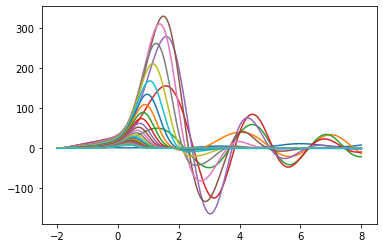

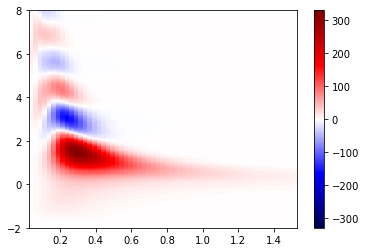

In [21]:
#make Binney Figure 9
rho_kps_cloud = np.trapz(f_kps_cloud,wPS,axis=3)
Sigma_kps_cloud = np.trapz(rho_kps_cloud,zPS,axis=2)
for i in range(0,nky,2):
    plt.plot(t/tscale,Sigma_kps_cloud[i])
plt.show()
vmx = np.abs(Sigma_kps_cloud).max()
c = plt.pcolormesh(kymesh,tmesh/tscale,Sigma_kps_cloud,cmap='seismic',vmin=-vmx,vmax=vmx)
plt.colorbar(c)
plt.show()

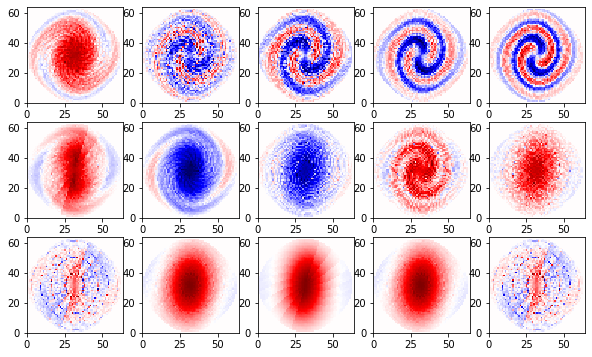

(60, 200) (30, 60) 60 200 30 60


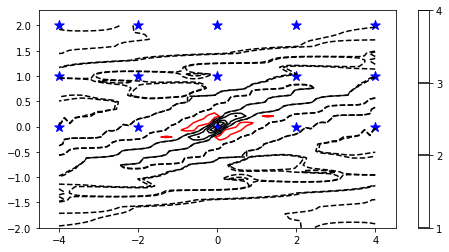

In [33]:
from scipy.ndimage import gaussian_filter

set_xygrid(nx,ny,2*lcrit,4*lcrit)

def IFT_zwDF(x,y,f):
    arg = 1j*(kxmesh*x+kymesh*y)
    FT = np.exp(arg)[:,:,None,None]*f*ky[:,None,None,None]
    zwdf = np.real(np.sum(FT+np.conj(FT),axis=(0,1))*dky)
    return zwdf

xplot = np.zeros((5,3))
yplot = np.zeros((5,3))
fig,ax = plt.subplots(3,5,figsize=(10,6))
for i in range(5):
    yplot[i,] = ymesh.max()*(i-2)/2
    for j in range(3):
        jj = 2-j
        xplot[:,j] = xmesh.max()*j/2
        zwdf = IFT_zwDF(xplot[i,j],yplot[i,j],f_kps_cloud+f_kzs_cloud)
        zwmax = np.abs(zwdf).max()
        ax[jj,i].pcolormesh(zwdf,vmin=-zwmax,vmax=zwmax,cmap='seismic')
plt.show()

Sigma_x = IFT_Sigma(Sigma_kps_cloud)
nlev = (-2,-1)
plev = (1,2,3,4)
Plot_Sigma(Sigma_x,nlev,plev)
plt.scatter(yplot/lcrit,xplot/lcrit,c='blue',marker='*',s=100)
plt.savefig('zwthumbnails.png')

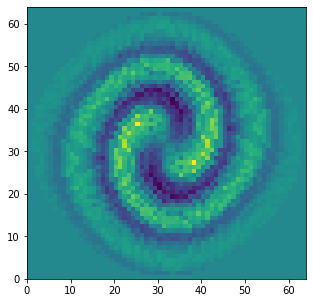

(64, 64)


In [37]:
i = 4
j = 2
fig,ax = plt.subplots(1,1,figsize=(5,5))
yplot[i,] = ymesh.max()*(i-2)/2
xplot[:,j] = xmesh.max()*(j)/2
zwdf = IFT_zwDF(xplot[i,j],yplot[i,j],f_kps_cloud+f_kzs_cloud)
ax.pcolormesh(zwdf)
plt.show()
np.savetxt('highSD.txt',zwdf)

zwdfcheck = np.loadtxt('highSD.txt',unpack=True)
print (zwdfcheck.shape)

NameError: name 'f_kze' is not defined

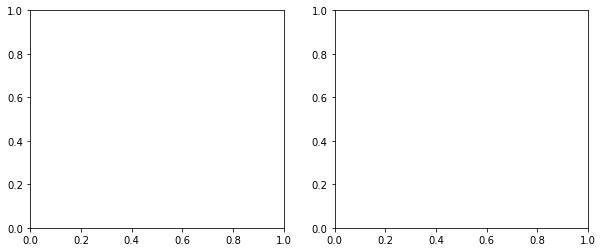

In [24]:
fig,ax = plt.subplots(1,2,figsize=(10,4))
nuPSM = PeriodfromE(EPSM)
ax[0].scatter(zPSM,wPSM,c=f_kze[3,40,])
thetaPSM = thetafromzw_fast(zPSM,wPSM)
ax[1].scatter(nuPSM,thetaPSM,c=f_kze[3,120])
ax[0].set_xlim(-0.012,0.012)
ax[1].set_xlim(nuPSM.min(),1.35)
print (nuPSM.max())
print (f_kze.max())